In [1]:
# import libraries
import collections
import os
import arcpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 12),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

In [2]:
# set geoprocessing environments
arcpy.env.workspace = r"C:\Users\Owner\Desktop\g670wk12"
arcpy.env.overwriteOutput = True    
from arcpy import env
from arcpy.sa import *

In [3]:
# Load - add Spatial Analyst
arcpy.CheckOutExtension("Spatial")
outputdir= r"C:\Users\Owner\Desktop\g670wk12"

In [4]:
# Define training and validation shape files
trainClass = r"C:\Users\Owner\Desktop\g670wk12\Stony_topo_train\Stony_topo_train.shp"
# validClass has to be replaced at each run because it will be updated at each run
# If it is not replaced, it will contain 2 times more fields, which will make the parameter list 
# and the RMSE list have different numbers, breaking the running sequence
validClass = r"C:\Users\Owner\Desktop\g670wk12\s_valid\s_valid.shp"

# Define the interpolation variable
varList = ['X', 'Y', 'Z']
varName = varList[2]
# print(varName)

# Define the parameters for the power and neighborhood parameters
powerVal = [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6] 
pointsNum =  [4, 6, 8, 10, 12, 14, 16, 22, 24]

# Define a list to save the interpolation outcomes
tiffList = []

# Define a list to save the power and neighbors indices
ppindex = []

In [5]:
# Perform the IDW interpolation
kk=0
for ii in powerVal:
    kk=kk+1
    for jj in pointsNum:
        #outSpline = arcpy.sa.Spline(featureClass, k, 250, "REGULARIZED", ii, jj)
        #outSpline.save("C:/Kite_Folder/Spline_output_2013_0712_0728/"+str(k)+"_"+str(ii)+"_"+str(jj)+".tif")
        #print (varName+str(ii)+"_"+str(jj)+" is done")
        #Idw(in_point_features, z_field, {cell_size}, {power}, {search_radius}, {in_barrier_polyline_features})
        
        outIDW = arcpy.sa.Idw(trainClass, varName, 5.0, ii, RadiusVariable(jj, 40)) 
        # outIDW.save("C:/Users/yxie/TEACH/g585/2023_Win/Week11/"+varName+str(kk)+"_"+str(jj)+".tif")
        output_path = os.path.join(outputdir, f"{varName}{ii}_{jj}.tif")
        outIDW.save(output_path)
        # print(varName+str(ii)+"_"+str(jj)+" is done")
        tiffList.append(outIDW)
        ppindex.append(varName+str(ii)+"_"+str(jj))
      
arcpy.sa.ExtractMultiValuesToPoints(validClass, tiffList)
arcpy.CheckInExtension("Spatial")
print(ppindex)

['Z0.8_4', 'Z0.8_6', 'Z0.8_8', 'Z0.8_10', 'Z0.8_12', 'Z0.8_14', 'Z0.8_16', 'Z0.8_22', 'Z0.8_24', 'Z1.0_4', 'Z1.0_6', 'Z1.0_8', 'Z1.0_10', 'Z1.0_12', 'Z1.0_14', 'Z1.0_16', 'Z1.0_22', 'Z1.0_24', 'Z1.2_4', 'Z1.2_6', 'Z1.2_8', 'Z1.2_10', 'Z1.2_12', 'Z1.2_14', 'Z1.2_16', 'Z1.2_22', 'Z1.2_24', 'Z1.4_4', 'Z1.4_6', 'Z1.4_8', 'Z1.4_10', 'Z1.4_12', 'Z1.4_14', 'Z1.4_16', 'Z1.4_22', 'Z1.4_24', 'Z1.6_4', 'Z1.6_6', 'Z1.6_8', 'Z1.6_10', 'Z1.6_12', 'Z1.6_14', 'Z1.6_16', 'Z1.6_22', 'Z1.6_24', 'Z1.8_4', 'Z1.8_6', 'Z1.8_8', 'Z1.8_10', 'Z1.8_12', 'Z1.8_14', 'Z1.8_16', 'Z1.8_22', 'Z1.8_24', 'Z2.0_4', 'Z2.0_6', 'Z2.0_8', 'Z2.0_10', 'Z2.0_12', 'Z2.0_14', 'Z2.0_16', 'Z2.0_22', 'Z2.0_24', 'Z2.2_4', 'Z2.2_6', 'Z2.2_8', 'Z2.2_10', 'Z2.2_12', 'Z2.2_14', 'Z2.2_16', 'Z2.2_22', 'Z2.2_24', 'Z2.4_4', 'Z2.4_6', 'Z2.4_8', 'Z2.4_10', 'Z2.4_12', 'Z2.4_14', 'Z2.4_16', 'Z2.4_22', 'Z2.4_24', 'Z2.6_4', 'Z2.6_6', 'Z2.6_8', 'Z2.6_10', 'Z2.6_12', 'Z2.6_14', 'Z2.6_16', 'Z2.6_22', 'Z2.6_24', 'Z2.8_4', 'Z2.8_6', 'Z2.8_8', 'Z2.8_10'

In [6]:
# Get the values for each field from the validation shapefile into tuples
field_names = [f.name for f in arcpy.ListFields(validClass)]
records_fc = set()
with arcpy.da.SearchCursor(validClass, field_names) as cursor:
    for row in cursor:
        records_fc.add(tuple(row))
#print(records_fc)

In [7]:
# Concert tuples into lists
dataList = []
dataList = [*records_fc,]

# Convert the list into dataframe
rmseData = pd.DataFrame(list(dataList))
#print(rmseData)

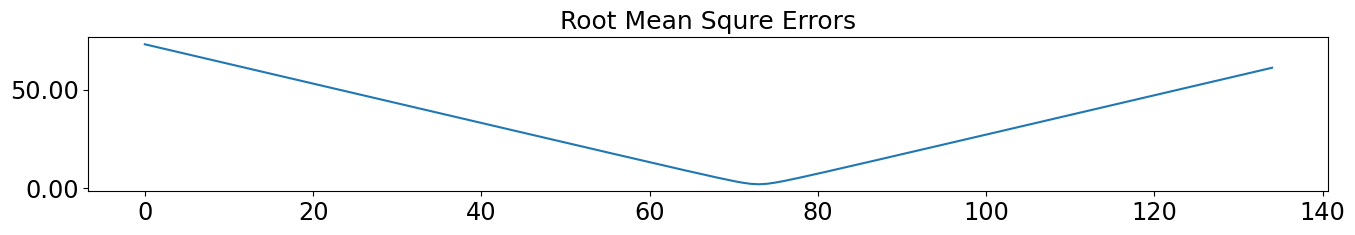

In [8]:
# Create a dataset to store RMSE
rmseSet = []
i = 0

# the observed value
Yobs = rmseData[2]
# print(Yobs)

# the intrpolated values
# Xint = rmseData[3:]
# print(Xint)

# Get rid of the 1st two columns
df = pd.DataFrame(rmseData)
dfT1 = df.T
dfT2 = dfT1[3:]
Xint = dfT2.T
# print(Xint)

# Compute the RMSE
for x in Xint:
    i=i+1
    # MSE = mean_squared_error(Yobs, x)
    # rmseSet.append(MSE)
    MSE = np.square(np.subtract(Yobs,x)).mean()
    RMSE = math.sqrt(MSE)
    # print("Root Mean Square Error:\n")
    # print(RMSE)
    rmseSet.append(RMSE)
    
# print(rmseSet)
# rmseSet.sort()
# print(rmseSet)

# Plot RMSE
plt.figure(figsize=(16,2))
plt.plot(rmseSet);
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'));
plt.title('Root Mean Squre Errors', fontsize=18);

In [9]:
# Write the results as a file
fileName = 'RMSEwithIndex'
Abspath = r"C:\Users\Owner\Desktop\g670wk12"
#print(ppindex)
#print("\n")
#print(rmseSet)
writer=pd.ExcelWriter(Abspath+fileName+'.xlsx')
d = {'PowerNeighbor': ppindex, 'RMSE': rmseSet}
df=DataFrame(data=d)
print(df)
df.to_excel(writer,'Sheet1')
writer.close()
print('success')

    PowerNeighbor       RMSE
0          Z0.8_4  72.987294
1          Z0.8_6  71.987629
2          Z0.8_8  70.987972
3         Z0.8_10  69.988326
4         Z0.8_12  68.988690
..            ...        ...
130       Z3.6_12  57.067546
131       Z3.6_14  58.067016
132       Z3.6_16  59.066504
133       Z3.6_22  60.066009
134       Z3.6_24  61.065530

[135 rows x 2 columns]
success


In [10]:
# Import packages
# Using the root environments
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [11]:
# Importing training data set
# Showing the data
X_train=pd.read_csv(r"C:\Users\Owner\Desktop\geog670Week13\X_train.csv")
Y_train=pd.read_csv(r"C:\Users\Owner\Desktop\geog670Week13\Y_train.csv")
# Importing testing data set
X_test=pd.read_csv(r"C:\Users\Owner\Desktop\geog670Week13\X_test.csv")
Y_test=pd.read_csv(r"C:\Users\Owner\Desktop\geog670Week13\Y_test.csv")

In [19]:
# Lets take a closer look at our data set.
print (X_train.head())


    Loan_ID Gender Married Dependents Education Self_Employed  \
0  LP001032   Male      No          0  Graduate            No   
1  LP001824   Male     Yes          1  Graduate            No   
2  LP002928   Male     Yes          0  Graduate            No   
3  LP001814   Male     Yes          2  Graduate            No   
4  LP002244   Male     Yes          0  Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             4950                0.0         125               360   
1             2882             1843.0         123               480   
2             3000             3416.0          56               180   
3             9703                0.0         112               360   
4             2333             2417.0         136               360   

   Credit_History Property_Area  
0               1         Urban  
1               1     Semiurban  
2               1     Semiurban  
3               1         Urban  
4           

array([[<AxesSubplot: title={'center': 'ApplicantIncome'}>,
        <AxesSubplot: title={'center': 'CoapplicantIncome'}>],
       [<AxesSubplot: title={'center': 'LoanAmount'}>,
        <AxesSubplot: title={'center': 'Loan_Amount_Term'}>],
       [<AxesSubplot: title={'center': 'Credit_History'}>,
        <AxesSubplot: >]], dtype=object)

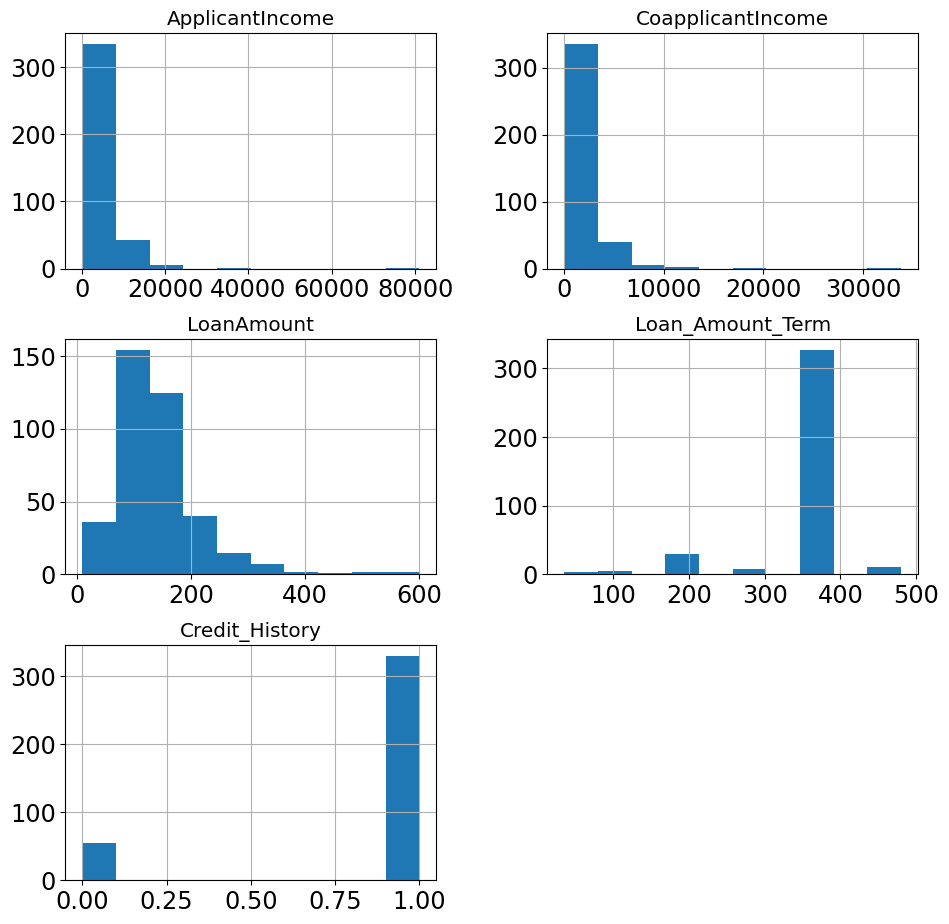

In [18]:
# Numerical Feature Exploration
X_train[X_train.dtypes[(X_train.dtypes=="float64")|(X_train.dtypes=="int64")]
                        .index.values].hist(figsize=[11,11])


In [20]:
# Importing MinMaxScaler and initializing it
from sklearn.preprocessing import MinMaxScaler
min_max=MinMaxScaler()
# Scaling down both train and test data set
# Why we are using numerical variables
X_train_minmax=min_max.fit_transform(X_train[['ApplicantIncome', 'CoapplicantIncome',
                'LoanAmount', 'Loan_Amount_Term', 'Credit_History']])
X_test_minmax=min_max.fit_transform(X_test[['ApplicantIncome', 'CoapplicantIncome',
                'LoanAmount', 'Loan_Amount_Term', 'Credit_History']])

In [21]:
# Fitting k-NN on our scaled data set
# Classifier implementing the k-nearest neighbors vote
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_minmax,Y_train)
# Checking the model's accuracy
accuracy_score(Y_test,knn.predict(X_test_minmax))

C:\Users\Owner\AppData\Roaming\Python\Python39\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.75

In [22]:
# Standardizing the train and test data
# What is the difference between Standardizing scale and MinMax scale
from sklearn.preprocessing import scale
X_train_scale=scale(X_train[['ApplicantIncome', 'CoapplicantIncome',
               'LoanAmount', 'Loan_Amount_Term', 'Credit_History']])
X_test_scale=scale(X_test[['ApplicantIncome', 'CoapplicantIncome',
               'LoanAmount', 'Loan_Amount_Term', 'Credit_History']])

# Fitting logistic regression on our standardized data set
from sklearn.linear_model import LogisticRegression
log=LogisticRegression(penalty='l2',C=.01)
log.fit(X_train_scale,Y_train)
# Checking the model's accuracy
accuracy_score(Y_test,log.predict(X_test_scale))

C:\Users\Owner\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.75

In [26]:
# Importing LabelEncoder and initializing it
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Iterating over all the common columns in train and test
for col in X_test.columns.values:
    # Encoding only categorical variables
    if X_test[col].dtypes == 'object':
        # Using whole data to form an exhaustive list of levels
        data = pd.concat([X_train[col], X_test[col]], axis=0)  # Concatenate Series into a DataFrame
        le.fit(data.values)
        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])


In [27]:
print(X_train.head())
print(X_train.tail())

   Loan_ID  Gender  Married  Dependents  Education  Self_Employed  \
0       13       1        0           0          0              0   
1      193       1        1           1          0              0   
2      461       1        1           0          0              0   
3      191       1        1           2          0              0   
4      300       1        1           0          0              0   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             4950                0.0         125               360   
1             2882             1843.0         123               480   
2             3000             3416.0          56               180   
3             9703                0.0         112               360   
4             2333             2417.0         136               360   

   Credit_History  Property_Area  
0               1              2  
1               1              1  
2               1              1  
3               1 

In [28]:
# Logistic regression
# Standardizing the features

X_train_scale=scale(X_train)
X_test_scale=scale(X_test)

# Fitting the logistic regression model

log=LogisticRegression(penalty='l2',C=.01)
log.fit(X_train_scale,Y_train)

# Checking the models accuracy
accuracy_score(Y_test,log.predict(X_test_scale))

C:\Users\Owner\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7395833333333334

In [32]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)

# Creating copies of X_train and X_test
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()

columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
           'Credit_History', 'Property_Area']

# Iterating through categorical columns
for col in columns:
    # Creating an exhaustive list of all possible categorical values
    data = pd.concat([X_train[[col]], X_test[[col]]], axis=0)
    enc.fit(data)

    # Fitting One Hot Encoding on train data
    temp_train = enc.transform(X_train[[col]])
    temp_train = pd.DataFrame(temp_train, columns=[(col + "_" + str(i)) for i in range(temp_train.shape[1])])
    temp_train = temp_train.set_index(X_train.index.values)
    X_train_1 = pd.concat([X_train_1, temp_train], axis=1)

    # Fitting One Hot Encoding on test data
    temp_test = enc.transform(X_test[[col]])
    temp_test = pd.DataFrame(temp_test, columns=[(col + "_" + str(i)) for i in range(temp_test.shape[1])])
    temp_test = temp_test.set_index(X_test.index.values)
    X_test_1 = pd.concat([X_test_1, temp_test], axis=1)


C:\Users\Owner\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Owner\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Owner\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Owner\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` wa

In [33]:
print(X_train_1.head())
print(X_train_1.tail())

   Loan_ID  Gender  Married  Dependents  Education  Self_Employed  \
0       13       1        0           0          0              0   
1      193       1        1           1          0              0   
2      461       1        1           0          0              0   
3      191       1        1           2          0              0   
4      300       1        1           0          0              0   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  ...  \
0             4950                0.0         125               360  ...   
1             2882             1843.0         123               480  ...   
2             3000             3416.0          56               180  ...   
3             9703                0.0         112               360  ...   
4             2333             2417.0         136               360  ...   

   Dependents_3  Education_0  Education_1  Self_Employed_0  Self_Employed_1  \
0           0.0          1.0          0.0        

In [34]:
# Now, lets apply logistic regression model on one-hot encoded data.
# Standardizing the data set
X_train_scale=scale(X_train_1)
X_test_scale=scale(X_test_1)

# Fitting a logistic regression model
log=LogisticRegression(penalty='l2',C=1)
log.fit(X_train_scale,Y_train)

# Checking the model's accuracy
accuracy_score(Y_test,log.predict(X_test_scale))

C:\Users\Owner\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.75

In [35]:
# Building Decision Tree
# Standardizing the data set
X_train_scale=scale(X_train_1)
X_test_scale=scale(X_test_1)

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
dt.fit(X_train_scale, Y_train)
accuracy_score(Y_test,dt.predict(X_test_scale))
text_representation = tree.export_text(dt)
print(text_representation)
with open("C:/Users/Owner/Desktop/geog670Week13/decistion_tree.log", "w") as fout:
    fout.write(text_representation)

|--- feature_25 <= -1.02
|   |--- feature_6 <= 0.05
|   |   |--- feature_6 <= -0.17
|   |   |   |--- feature_8 <= -0.67
|   |   |   |   |--- feature_7 <= -0.13
|   |   |   |   |   |--- class: N
|   |   |   |   |--- feature_7 >  -0.13
|   |   |   |   |   |--- class: Y
|   |   |   |--- feature_8 >  -0.67
|   |   |   |   |--- class: N
|   |   |--- feature_6 >  -0.17
|   |   |   |--- feature_8 <= 0.07
|   |   |   |   |--- feature_26 <= 0.45
|   |   |   |   |   |--- class: N
|   |   |   |   |--- feature_26 >  0.45
|   |   |   |   |   |--- class: Y
|   |   |   |--- feature_8 >  0.07
|   |   |   |   |--- class: Y
|   |--- feature_6 >  0.05
|   |   |--- class: N
|--- feature_25 >  -1.02
|   |--- feature_7 <= 3.04
|   |   |--- feature_27 <= 0.25
|   |   |   |--- feature_0 <= 1.53
|   |   |   |   |--- feature_6 <= -0.69
|   |   |   |   |   |--- feature_0 <= -1.61
|   |   |   |   |   |   |--- class: Y
|   |   |   |   |   |--- feature_0 >  -1.61
|   |   |   |   |   |   |--- feature_7 <= 0.68
|   |

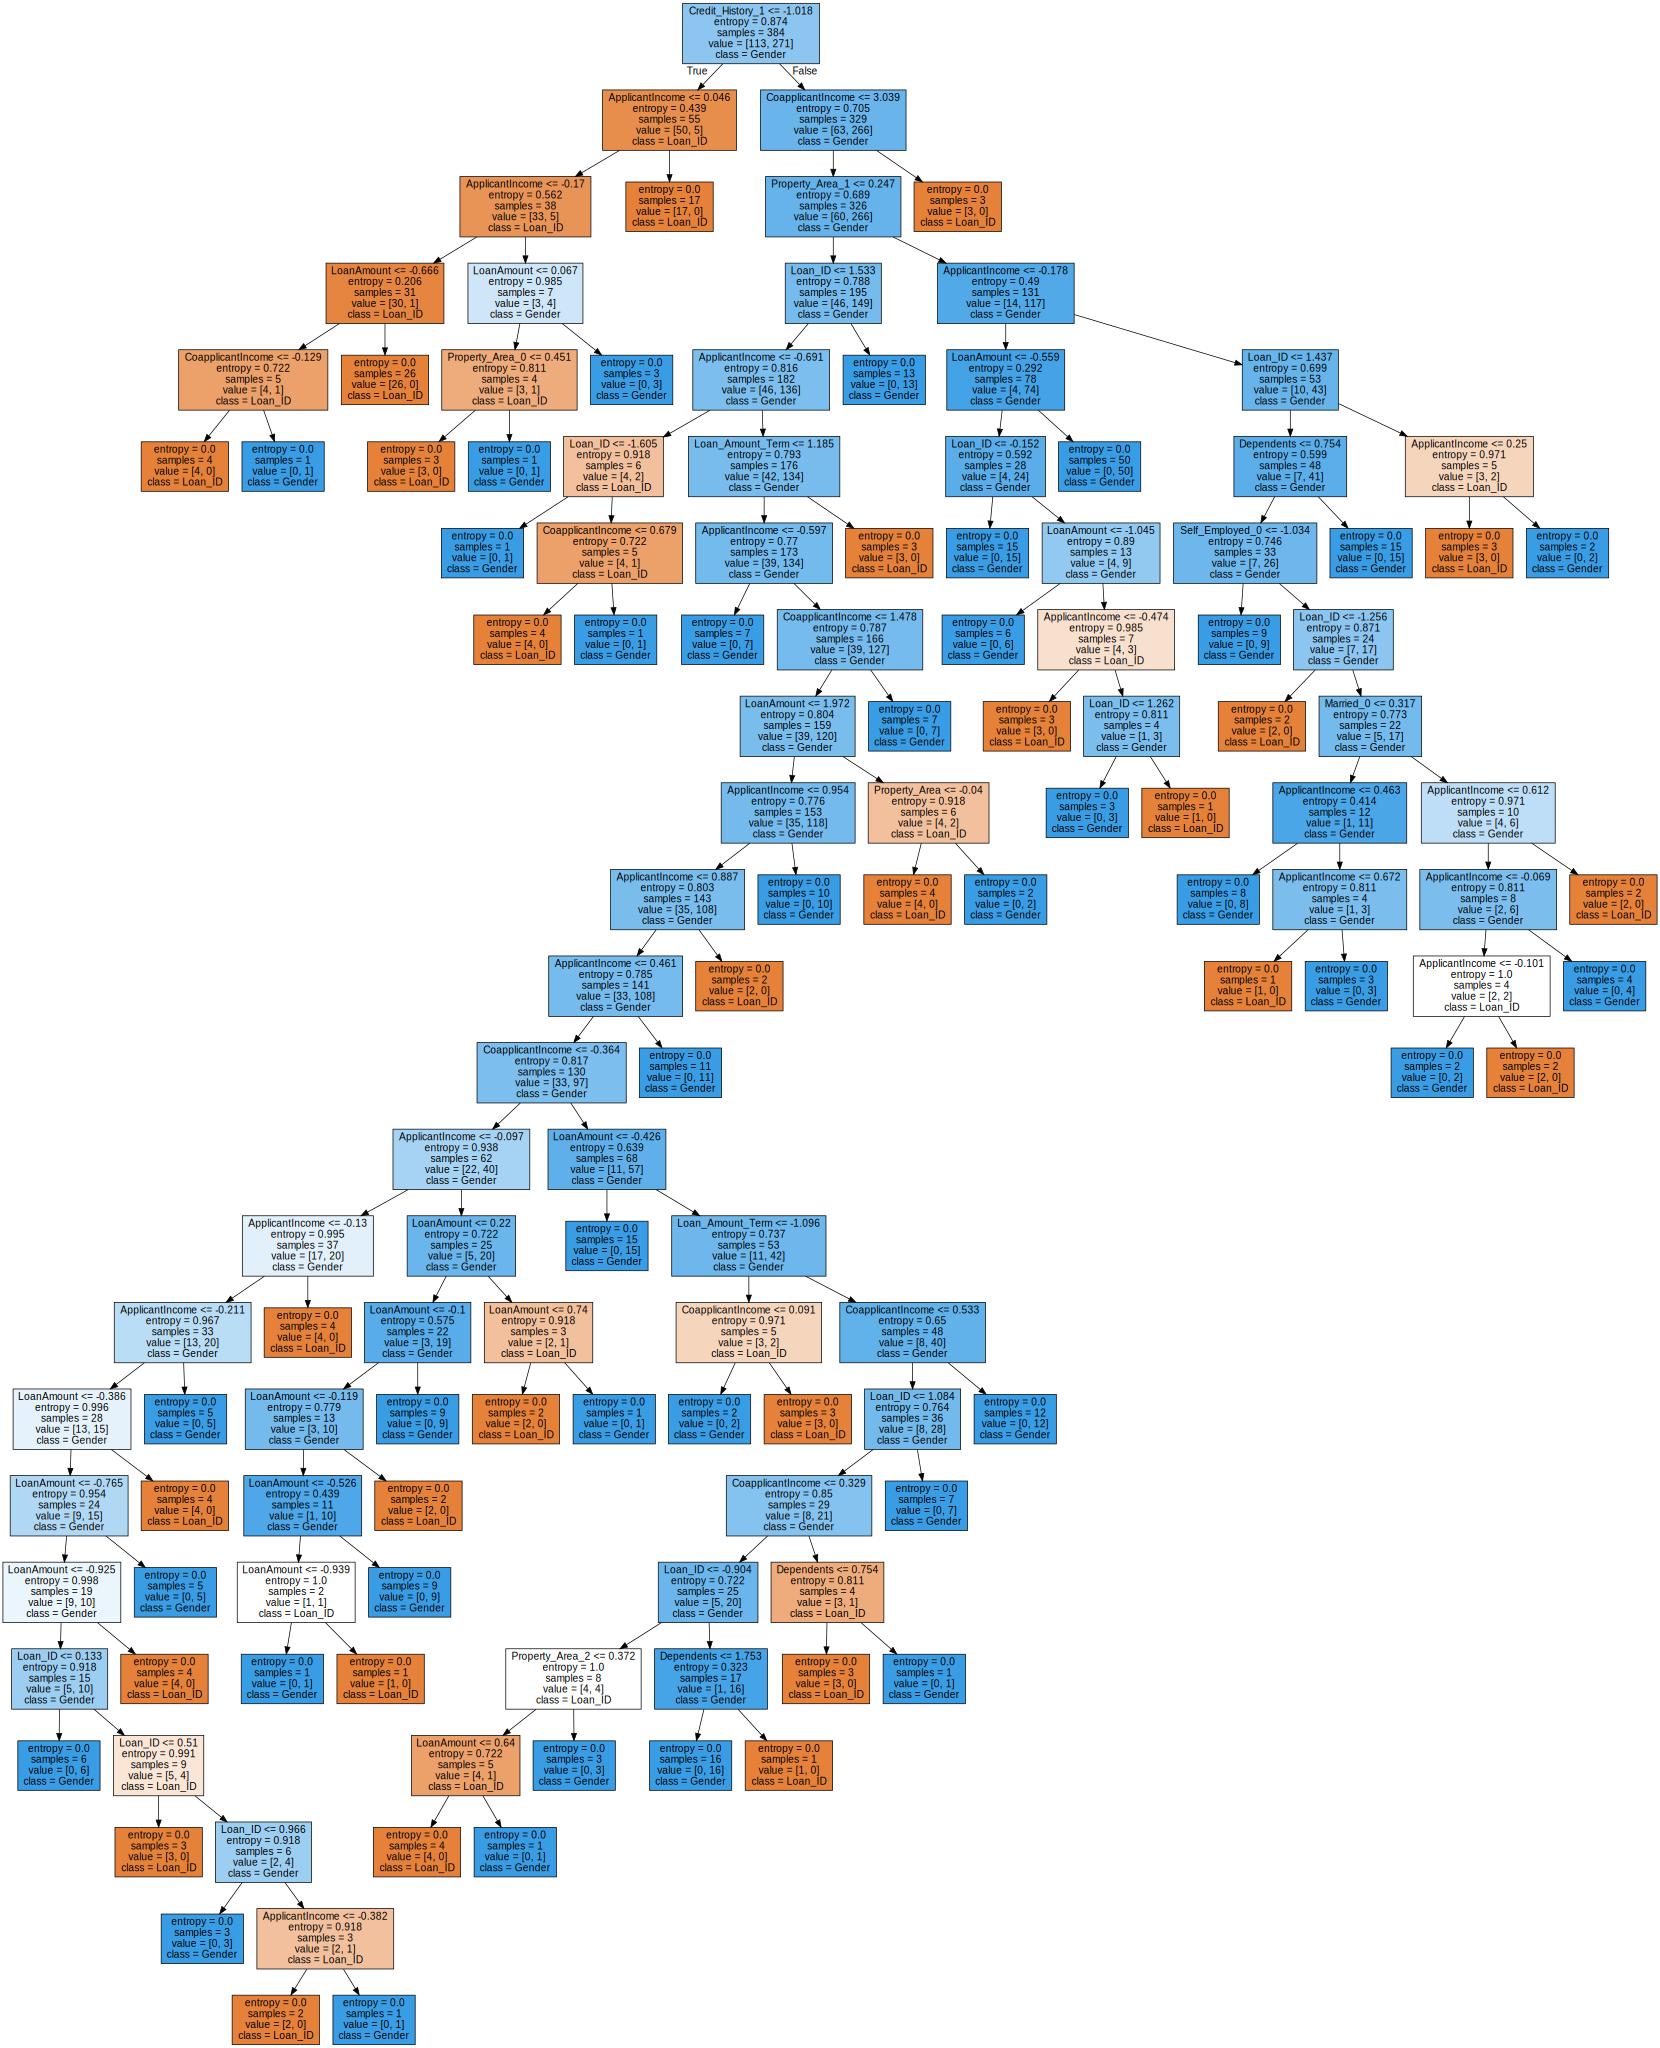

In [36]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=X_train_1.columns.values,  
                                class_names=X_train_1.columns.values,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

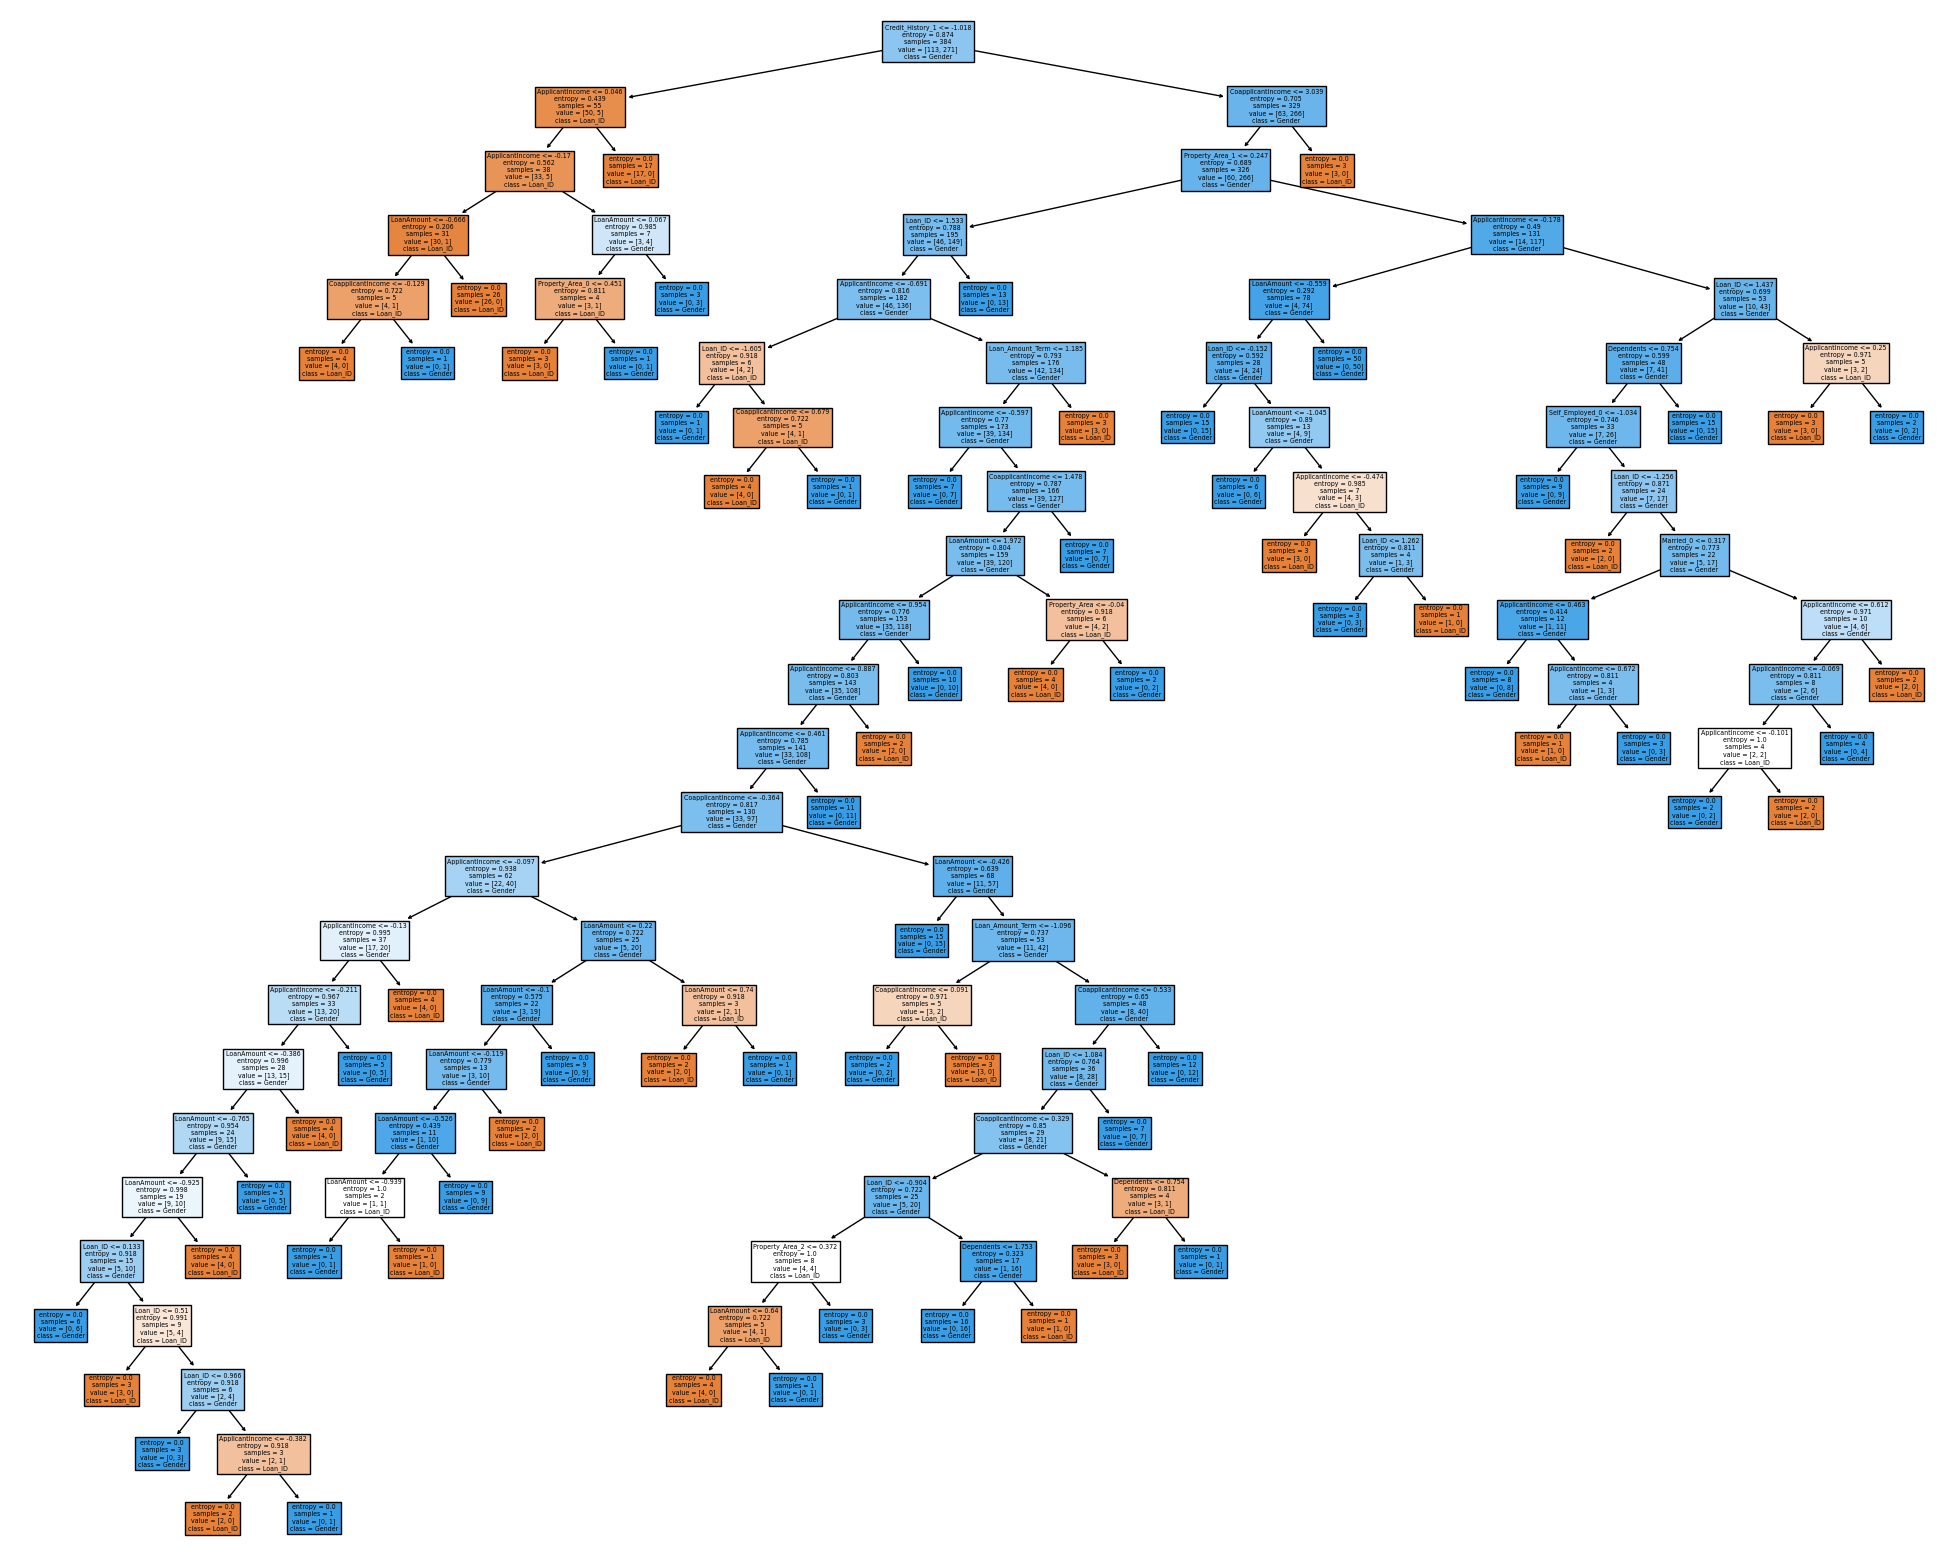

In [37]:
plt.figure(figsize=(25,20))
# _ = tree.plot_tree(dt, 
#                    feature_names=X_train_scale.feature_names,  
#                   class_names=Y_train_scale.target_names,
#                   filled=True)
_ = tree.plot_tree(dt, 
                   feature_names=X_train_1.columns.values,  
                   class_names=X_train_1.columns.values,
                   filled=True)